In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import cv2
import sklearn
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import tflite as tflite

In [3]:
training_dir = 'dataset/training_set'
test_dir = 'dataset/test_set'
image_size = (64,64)
batch_size = 32

In [4]:
# Create an ImageDataGenerator instance for data loading and augmentation
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,        # Scale pixel values to range [0, 1]
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=20,     # Randomly rotate images by up to 20 degrees
    shear_range=0.2,       # Apply shear transformation
    zoom_range=0.2,        # Apply random zoom
    width_shift_range=0.1, # Randomly shift images horizontally
    height_shift_range=0.1 # Randomly shift images vertically
)

In [5]:
# Load images from the directory structure
train_generator = data_generator.flow_from_directory(
    training_dir,       # Path to the target directory
    target_size=image_size, # Resize images to specified size
    batch_size=batch_size,  # Number of images to load in each batch
    class_mode='categorical',    # Type of label: 'categorical' for multi-class classification
    color_mode='grayscale'
)

Found 39365 images belonging to 26 classes.


In [6]:
# Load images from the directory structure
val_generator = data_generator.flow_from_directory(
    test_dir,       # Path to the target directory
    target_size=image_size, # Resize images to specified size
    batch_size=batch_size,  # Number of images to load in each batch
    class_mode='categorical',    # Type of label: 'categorical' for multi-class classification
    color_mode='grayscale'
)

Found 5200 images belonging to 26 classes.


In [7]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(64,64,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=26,activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [9]:
# Define the learning rate
learning_rate = 0.00001  # Adjust this value according to your needs

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

In [10]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)

history = model.fit(
    train_generator,          # Use the data generator directly
    epochs=50,
    validation_data=val_generator,  # Use the validation generator
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

Epoch 1/50
1231/1231 [==============================] - 99s 80ms/step - loss: 2.8776 - accuracy: 0.2209 - val_loss: 2.0527 - val_accuracy: 0.4683 - lr: 1.0000e-05
Epoch 2/50
1231/1231 [==============================] - 109s 88ms/step - loss: 1.7327 - accuracy: 0.4840 - val_loss: 1.3478 - val_accuracy: 0.6137 - lr: 1.0000e-05
Epoch 3/50
1231/1231 [==============================] - 107s 87ms/step - loss: 1.3409 - accuracy: 0.5881 - val_loss: 1.1186 - val_accuracy: 0.6663 - lr: 1.0000e-05
Epoch 4/50
1231/1231 [==============================] - 107s 87ms/step - loss: 1.1375 - accuracy: 0.6475 - val_loss: 0.9193 - val_accuracy: 0.7406 - lr: 1.0000e-05
Epoch 5/50
1231/1231 [==============================] - 108s 88ms/step - loss: 0.9890 - accuracy: 0.6952 - val_loss: 0.7676 - val_accuracy: 0.7787 - lr: 1.0000e-05
Epoch 6/50
1231/1231 [==============================] - 116s 94ms/step - loss: 0.8652 - accuracy: 0.7287 - val_loss: 0.6668 - val_accuracy: 0.8115 - lr: 1.0000e-05
Epoch 7/50
1231/1

In [12]:
model.save('asl_model.keras') #try h5 format
#model = tf.keras.models.load_model('my_model.keras')

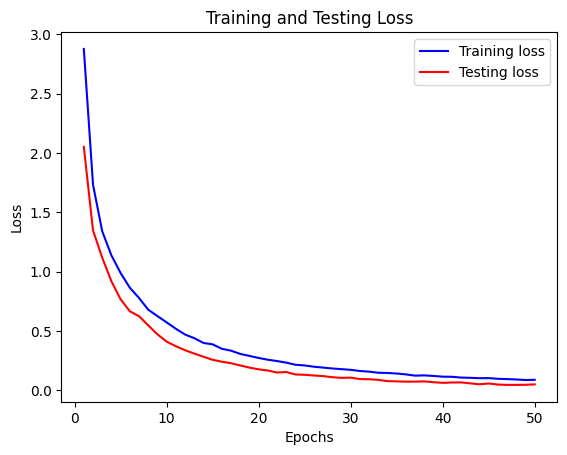

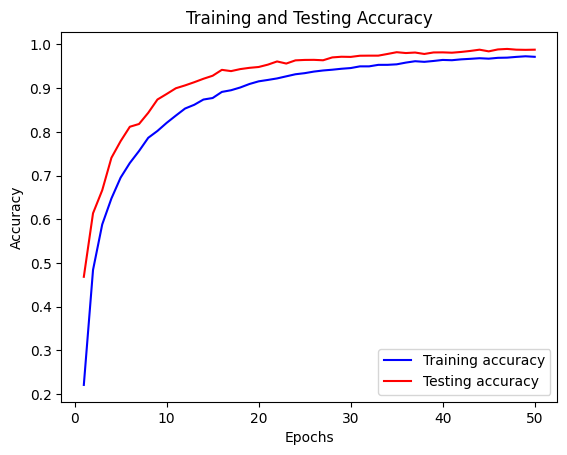

In [13]:
# Get training and testing loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and testing accuracy
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create epochs range
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
hash_map = { 
    0: "A",
    1: "B",
    2: "C",
    3: "D",  
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
    25: "Z",
}

def hash_find(variable_name):
    return hash_map.get(variable_name, None)

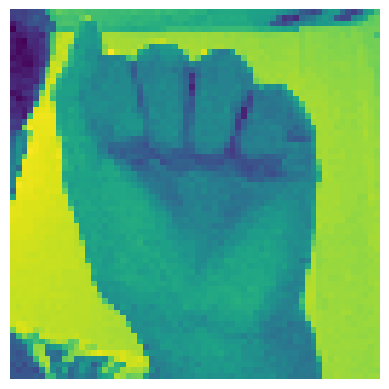

In [22]:
# Load the image using OpenCV
img = cv2.imread('test_image.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 64x64 pixels
img_resized = cv2.resize(img, (64, 64))

# Normalize the pixel values (convert to float and scale to [0, 1])
img_resized = img_resized.astype('float32') / 255.0

# Expand dimensions to match the input shape expected by the model
img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension

# Prepare the image for input to the model
img_input = np.expand_dims(img_resized, axis=0)  # Add batch dimension

# Optionally, you can visualize the resized image
import matplotlib.pyplot as plt
plt.imshow(img_resized)
plt.axis('off')
plt.show()

In [23]:
prediction = model.predict(img_input)

1/1 [==============================] - 0s 12ms/step


Predicted Class: 18
Meaning in Sign Language: S


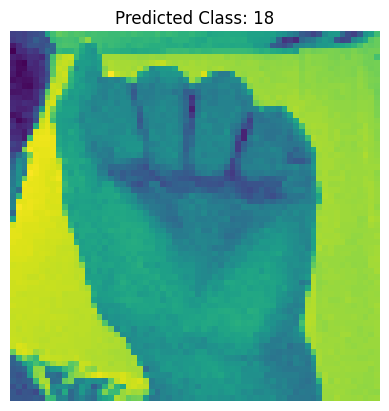

In [24]:
# Postprocess the prediction
predicted_class = np.argmax(prediction)

# Print the predicted class or use it for further processing
print("Predicted Class:", predicted_class)
print("Meaning in Sign Language:", hash_find(predicted_class))

# Visualize the original image with predicted class (optional)
plt.imshow(img_resized)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

In [16]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/fn/4_3b5y750f17m2j_7w_rysbm0000gn/T/tmp9l8ljwp0/assets


INFO:tensorflow:Assets written to: /var/folders/fn/4_3b5y750f17m2j_7w_rysbm0000gn/T/tmp9l8ljwp0/assets
2024-04-27 15:38:54.544148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-27 15:38:54.544160: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-27 15:38:54.544398: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/fn/4_3b5y750f17m2j_7w_rysbm0000gn/T/tmp9l8ljwp0
2024-04-27 15:38:54.545244: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-27 15:38:54.545248: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/fn/4_3b5y750f17m2j_7w_rysbm0000gn/T/tmp9l8ljwp0
2024-04-27 15:38:54.546692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-27 15:38:54.547275: I tensorflow/cc/saved_model/load

In [17]:
with open('asl_model.tflite', 'wb') as f:
  f.write(tflite_model)